# Import Library

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os
import shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from skimage.exposure import rescale_intensity

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
# import tensorflow_addons as tfa

from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2





# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Data Preparation

## Data Loading


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (8).json


{'kaggle (8).json': b'{"username":"rifdahhansya","key":"5e933f3319954689fbd0c111c9136772"}'}

In [3]:
!pip install kaggle


In [4]:

# 3. Setup kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download dataset
!kaggle datasets download -d samahsadiq/benign-and-malicious-qr-codes

# 5. Unzip dataset
!unzip benign-and-malicious-qr-codes.zip


Streaming output truncated to the last 5000 lines.
  inflating: QR codes/malicious/malicious/malicious_411254.png  
  inflating: QR codes/malicious/malicious/malicious_411255.png  
  inflating: QR codes/malicious/malicious/malicious_411256.png  
  inflating: QR codes/malicious/malicious/malicious_411257.png  
  inflating: QR codes/malicious/malicious/malicious_411258.png  
  inflating: QR codes/malicious/malicious/malicious_411259.png  
  inflating: QR codes/malicious/malicious/malicious_411260.png  
  inflating: QR codes/malicious/malicious/malicious_411261.png  
  inflating: QR codes/malicious/malicious/malicious_411262.png  
  inflating: QR codes/malicious/malicious/malicious_411263.png  
  inflating: QR codes/malicious/malicious/malicious_411264.png  
  inflating: QR codes/malicious/malicious/malicious_411265.png  
  inflating: QR codes/malicious/malicious/malicious_411266.png  
  inflating: QR codes/malicious/malicious/malicious_411267.png  
  inflating: QR codes/malicious/malicio

In [5]:
!ls "QR codes/"

benign	malicious


In [6]:
# Fungsi untuk memindahkan isi subfolder ke folder induk
def flatten_directory(path):
    subdir = os.path.join(path, os.path.basename(path))  # contoh: QR codes/malicious/malicious
    if os.path.exists(subdir):
        for filename in os.listdir(subdir):
            src = os.path.join(subdir, filename)
            dst = os.path.join(path, filename)
            shutil.move(src, dst)
        os.rmdir(subdir)

# Jalankan untuk masing-masing folder
flatten_directory("QR codes/malicious")
flatten_directory("QR codes/benign")

## Data Preprocessing

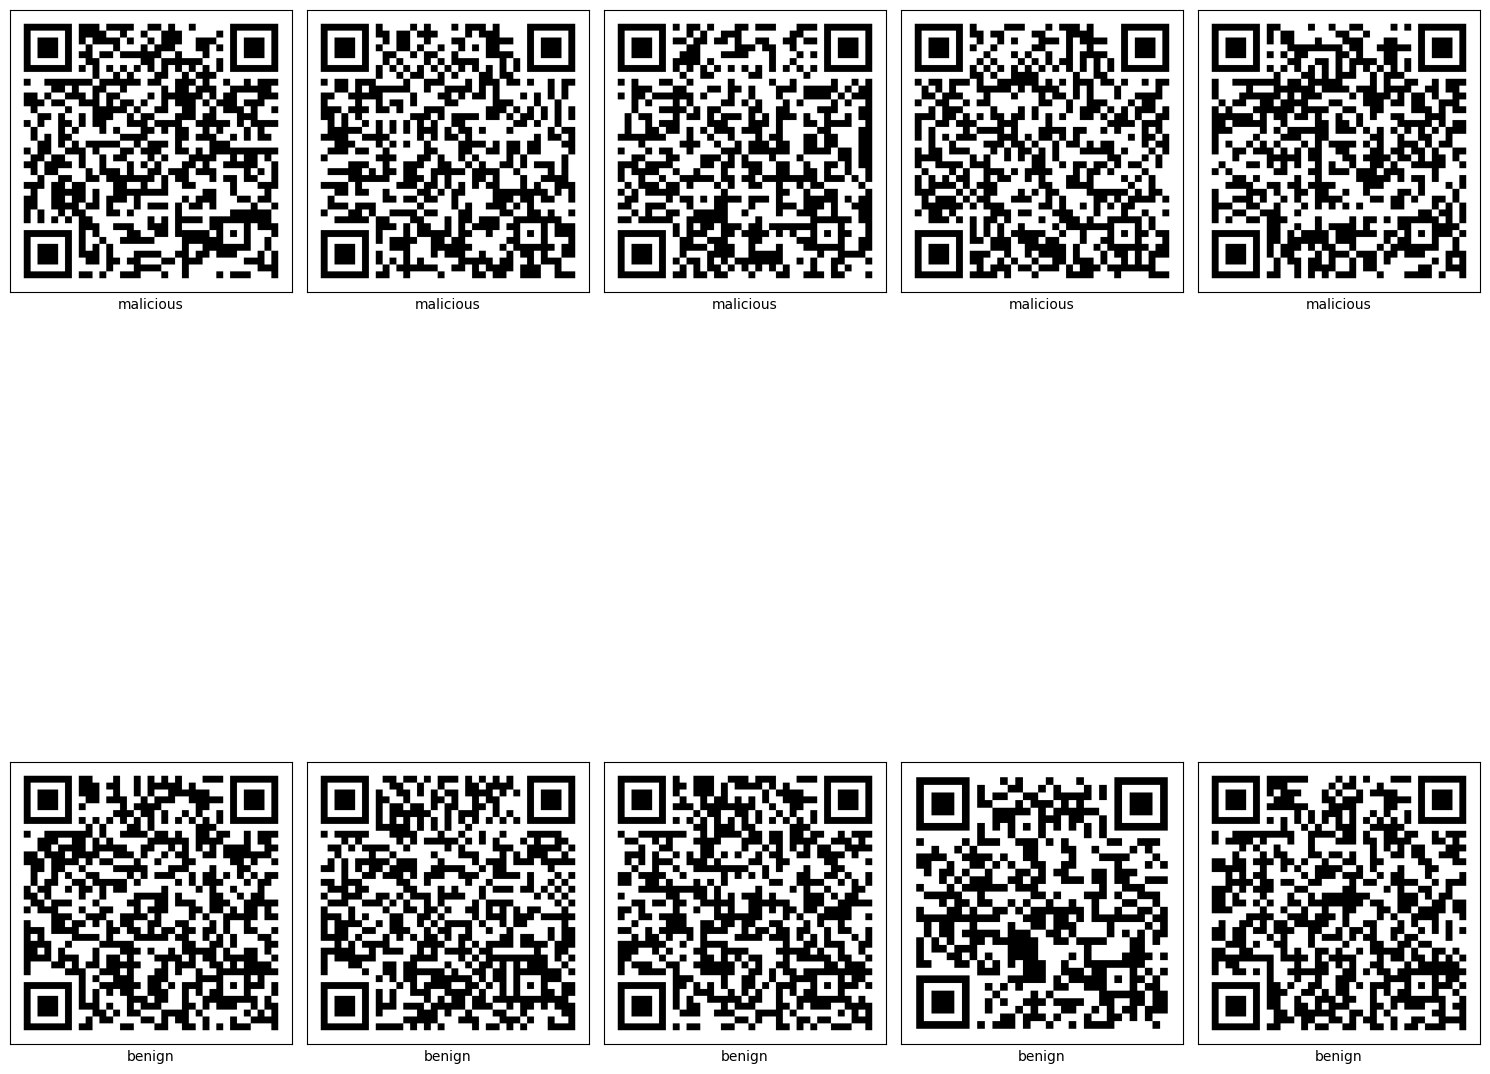

In [7]:
# Path ke dataset
path = "QR codes/"

# Membuat dictionary untuk menyimpan daftar gambar dalam setiap kelas
qr_img = {}

# Baca daftar kelas dan file gambar dalam setiap kelas
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        qr_img[class_name] = os.listdir(class_path)

# Menampilkan secara acak 5 gambar dari setiap kelas
fig, axs = plt.subplots(len(qr_img.keys()), 5, figsize=(15, 20))

for i, class_name in enumerate(qr_img.keys()):
    images = np.random.choice(qr_img[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)  # Tidak diubah ke grayscale
        axs[i, j].imshow(img)

        # Gunakan nama kelas dalam bahasa Inggris jika ada di kamus translate
        # label = translate.get(class_name, class_name)

        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

## EDA

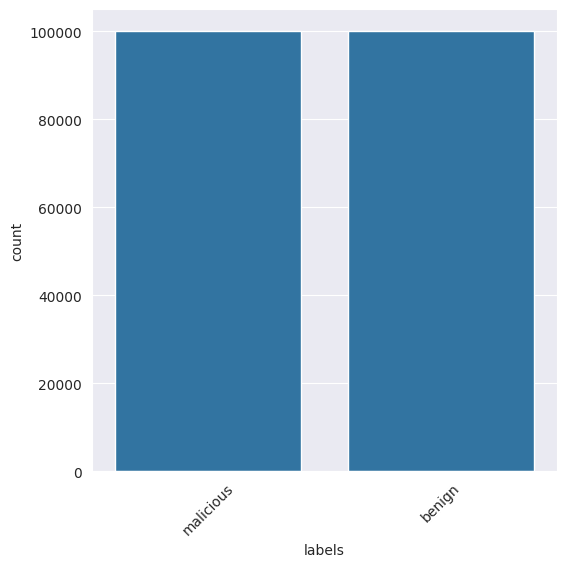

In [8]:
qr_path = "QR codes/"

# List untuk menyimpan informasi gambar
file_name = []
labels = []
full_path = []

# Loop untuk membaca gambar dalam folder dataset
for path, subdirs, files in os.walk(qr_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(os.path.basename(path))  # Ambil nama folder sebagai label
        file_name.append(name)

# Buat dataframe dengan label yang sudah diterjemahkan
distribution_train = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

# Plot distribusi gambar per kelas
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
sns.countplot(data=distribution_train, x="labels", order=distribution_train["labels"].value_counts().index)
plt.xticks(rotation=45)
plt.show()

## Split Dataset

In [9]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'QR codes/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
benign,100000
malicious,100000


In [10]:
# Batasi masing-masing label menjadi 50.000
df_balanced = df.groupby('labels', group_keys=False).apply(lambda x: x.sample(5000, random_state=42)).reset_index(drop=True)

# Cek jumlah data setelah dibatasi
print(df_balanced['labels'].value_counts())


labels
benign       5000
malicious    5000
Name: count, dtype: int64


<ipython-input-10-296093639aee>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('labels', group_keys=False).apply(lambda x: x.sample(5000, random_state=42)).reset_index(drop=True)


In [11]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df_balanced['path']
y= df_balanced['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [12]:
# Menyatukan ke dalam masing-masing DataFrame
df_train = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_test = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [13]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_train))
# print('test size', len(df_val))
print('test size', len(df_test))

train size 8000
test size 2000


In [14]:
# Menggabungkan semua DataFrame
df_all = pd.concat([df_train, df_test], ignore_index=True)

# Menampilkan jumlah data di setiap set dan label
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   benign       1012
       malicious     988
train  benign       3988
       malicious    4012
dtype: int64 


                                         path     labels    set
6979  QR codes/malicious/malicious_321783.png  malicious  train
5968  QR codes/malicious/malicious_359290.png  malicious  train
7134         QR codes/benign/benign_15690.png     benign  train
6854         QR codes/benign/benign_47833.png     benign  train
3082  QR codes/malicious/malicious_337173.png  malicious  train


In [28]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "QR codes/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [47]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## Image Data Generator

In [17]:
!ls Dataset-Final/test

benign	malicious


In [45]:
import shutil

# Hapus folder Dataset-Final jika ada, lalu buat ulang
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)

os.makedirs(dataset_path)


In [48]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"


train_ben = os.path.join(TRAIN_DIR + '/benign')
train_mal = os.path.join(TRAIN_DIR + '/malicious')

test_ben = os.path.join(TEST_DIR + '/benign')
test_mal = os.path.join(TEST_DIR + '/malicious')

print("Total number of Benign images in training set: ",len(os.listdir(train_ben)))
print("Total number of Malicious images in training set: ",len(os.listdir(train_mal)))


print("Total number of Benign images in test set: ",len(os.listdir(test_ben)))
print("Total number of Malicious images in test set: ",len(os.listdir(test_mal)))

Total number of Benign images in training set:  3988
Total number of Malicious images in training set:  4012
Total number of Benign images in test set:  1012
Total number of Malicious images in test set:  988


In [83]:
# Data augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=3,               # Sedikit rotasi, jangan lebih dari 5°
    width_shift_range=0.05,        # Geser horizontal sedikit
    height_shift_range=0.05,       # Geser vertikal sedikit
    zoom_range=0.05,               # Zoom kecil
    brightness_range=[0.9, 1.1],   # Pencahayaan ringan
    fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128, 128),
    batch_size=128,
    class_mode='binary',
    color_mode='rgb',  # <-- ini penting
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=128,
    target_size=(128,128),
    class_mode='binary',
    color_mode='rgb',  # <-- ini penting
    subset='validation',  # Ambil 20% untuk validasi
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=128,
    target_size=(128,128),
    class_mode='binary',
    color_mode='rgb',  # <-- ini penting
    shuffle=False
)


Found 8000 images belonging to 2 classes.
Found 1599 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Modeling

In [89]:
tf.keras.backend.clear_session()


In [90]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

initial_learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,705,921 (14.14 MB)

 Trainable params: 3,705,921 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Config Callbaks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [92]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [93]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5285 - loss: 1.2761

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.68793, saving model to best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.5290 - loss: 1.2695 - val_accuracy: 0.6879 - val_loss: 0.6319 - learning_rate: 0.0010
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6607 - loss: 0.6174
Epoch 2: val_accuracy improved from 0.68793 to 0.77298, saving model to best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 237s 4s/step - accuracy: 0.6611 - loss: 0.6170 - val_accuracy: 0.7730 - val_loss: 0.4805 - learning_rate: 0.0010
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7387 - loss: 0.5229
Epoch 3: val_accuracy improved from 0.77298 to 0.84365, saving model to best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 239s 4s/step - accuracy: 0.7389 - loss: 0.5225 - val_accuracy: 0.8437 - val_loss: 0.3677 - learning_rate: 0.0010
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7872 - loss: 0.4433
Epoch 4: val_accuracy did not improve from 0.84365
63/63 ━━━━━━━━━

# Evaluasi dan Visualisasi

In [94]:
# Evaluate the model
evaluation = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 959ms/step - accuracy: 0.9567 - loss: 0.0750
Loss: 0.08143716305494308
Accuracy: 0.9604166746139526


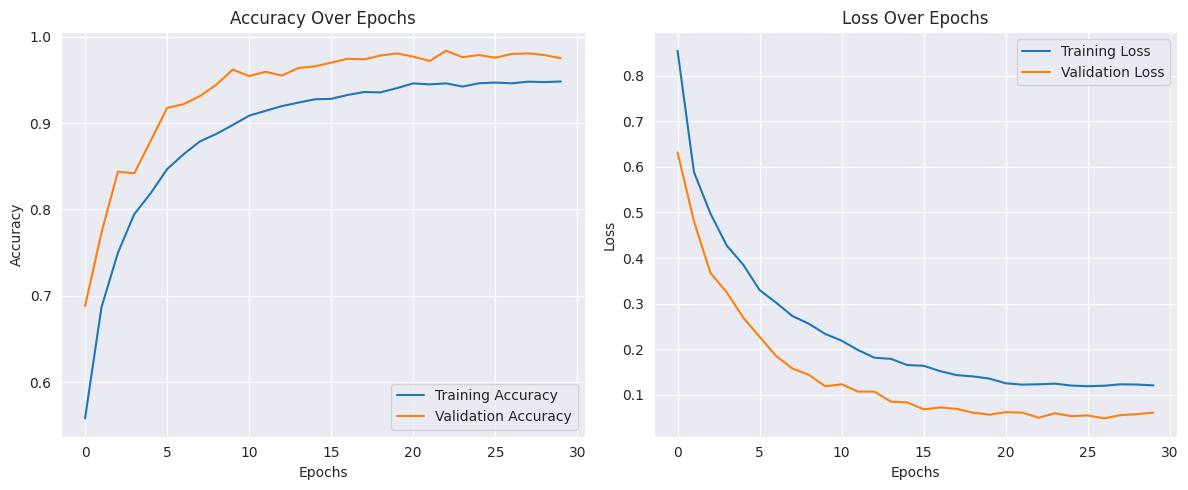

In [97]:
# Plot Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy') # Changed hist to history
plt.plot(history.history.get('val_accuracy', []), label='Validation Accuracy') # Changed hist to history
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss') # Changed hist to history
plt.plot(history.history.get('val_loss', []), label='Validation Loss') # Changed hist to history
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save Model

In [95]:
model.save('my_model.h5')

In [96]:
# Load the model
model = tf.keras.models.load_model('my_model.h5')

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


Saved artifact at '/tmp/tmpl4p6ao5g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132645062779408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132645022446800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132645022442192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132645022441040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132645022436816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132645022439120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132645022446032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132645022442960: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [108]:
model.save('my_model.keras')

# Inference

In [100]:
# prompt: buat inference dari model tersebut dengan menggunakan format model.tflite dengan mengambil input gambar dari user

import tensorflow as tf
import numpy as np
from PIL import Image
from google.colab import files

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((128, 128))
    img_array = np.array(img) / 255.0
    img_array = img_array.astype(np.float32)  # Change the data type to float32
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Upload an image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Preprocess the image
input_data = preprocess_image(image_path)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output
output_data = interpreter.get_tensor(output_details[0]['index'])

# Interpret the output
prediction = output_data[0][0]
if prediction > 0.5:
    print("Malicious QR Code")
else:
    print("Benign QR Code")



Saving phishing-qr.jpg to phishing-qr (1).jpg
Malicious QR Code
